In [1]:
import matplotlib.pyplot as plt
import os
import torch 
from torch.utils.data import DataLoader
import json
import sys
import torch

sys.path.append("src")
os.chdir('/home/george-vengrovski/Documents/projects/tweety_bert_paper')

from data_class import CollateFunction
from utils import load_model

weights_path = "/media/george-vengrovski/Extreme SSD/YardenLLB3_PreExtracted_WithPitch_Shift/saved_weights/model_step_26500.pth"
config_path = "/media/george-vengrovski/Extreme SSD/YardenLLB3_PreExtracted_WithPitch_Shift/config.json"

tweety_bert_model = load_model(config_path, weights_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Data Class

In [2]:
from torch.utils.data import DataLoader
from data_class import SongDataSet_Image, deterimine_number_unique_classes

train_dir = "/media/george-vengrovski/Extreme SSD/yarden_data/llb3_data_matrices_train"
test_dir = "/media/george-vengrovski/Extreme SSD/yarden_data/llb3_data_matrices_test"

num_classes = deterimine_number_unique_classes(train_dir)

train_dataset = SongDataSet_Image(train_dir, num_classes=num_classes, infinite_loader=False)
test_dataset = SongDataSet_Image(test_dir, num_classes=num_classes, infinite_loader=False)

collate_fn = CollateFunction(segment_length=1000)  # Adjust the segment length if needed

train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=48, shuffle=True, collate_fn=collate_fn)

## Define Linear Classifier and Train

In [3]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

classifier_model = LinearProbeModel(num_classes=num_classes, model_type="neural_net", model=tweety_bert_model, freeze_layers=True, layer_num=2, layer_id="attention_output", TweetyBERT_readout_dims=196, classifier_type="linear_probe")
classifier_model = classifier_model.to(device)

Step 1: Train Loss 3.7693 FER = 49.56%, Val Loss = 1.7812
Step 2: Train Loss 1.6322 FER = 27.32%, Val Loss = 1.0276
Step 3: Train Loss 1.1242 FER = 23.10%, Val Loss = 0.8848
Step 4: Train Loss 0.7690 FER = 18.38%, Val Loss = 0.6542
Step 5: Train Loss 0.7710 FER = 18.63%, Val Loss = 0.7314
Step 6: Train Loss 0.5914 FER = 12.21%, Val Loss = 0.4085
Step 7: Train Loss 0.5509 FER = 11.42%, Val Loss = 0.4398
Step 8: Train Loss 0.4752 FER = 9.85%, Val Loss = 0.4304
Step 9: Train Loss 0.3891 FER = 9.23%, Val Loss = 0.4016
Step 10: Train Loss 0.3631 FER = 10.01%, Val Loss = 0.3570
Step 11: Train Loss 0.3005 FER = 10.77%, Val Loss = 0.4048
Step 12: Train Loss 0.3027 FER = 6.87%, Val Loss = 0.2291
Step 13: Train Loss 0.3179 FER = 9.22%, Val Loss = 0.3424
Step 14: Train Loss 0.3585 FER = 9.17%, Val Loss = 0.3261
Step 15: Train Loss 0.3551 FER = 7.87%, Val Loss = 0.3107
Early stopping triggered


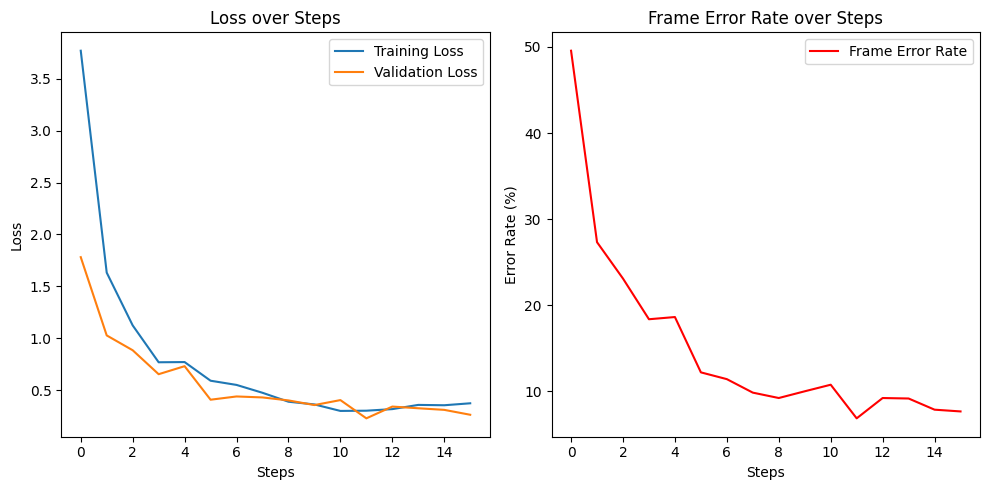

In [4]:
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=3e-4, plotting=True, batches_per_eval=1, desired_total_batches=50, patience=4)
trainer.train()

## Analyze

Evaluating:   0%|          | 0/1250 [00:00<?, ?batch/s]

spec shape: torch.Size([48, 1, 196, 1000]), label shape: torch.Size([48, 1000, 21]), vocalization shape: torch.Size([48, 1000])
spec shape: torch.Size([48, 1, 196, 1000]), label shape: torch.Size([48, 1000, 21]), vocalization shape: torch.Size([48, 1000])
predicted labels: tensor([[12, 12, 12,  ...,  3,  3,  3],
        [ 0,  2,  2,  ...,  3,  3,  3],
        [ 0,  0,  0,  ...,  3,  3,  3],
        ...,
        [ 0,  0, 17,  ...,  0,  0,  0],
        [ 6,  6,  6,  ...,  1,  1,  0],
        [ 0,  3,  3,  ...,  3,  3,  3]], device='cuda:0'), true labels: tensor([[12, 12, 12,  ...,  3,  3,  3],
        [ 0,  2,  2,  ...,  0,  0,  0],
        [ 9,  9,  9,  ...,  3,  3,  3],
        ...,
        [17, 17, 17,  ...,  0,  0,  0],
        [ 6,  6,  6,  ...,  1,  1,  1],
        [ 0,  0,  1,  ...,  0, 14, 14]], device='cuda:0')
percentage of correct: 92.21458333333334, percentage of incorrect: 7.785416666666666


ValueError: Axis limits cannot be NaN or Inf

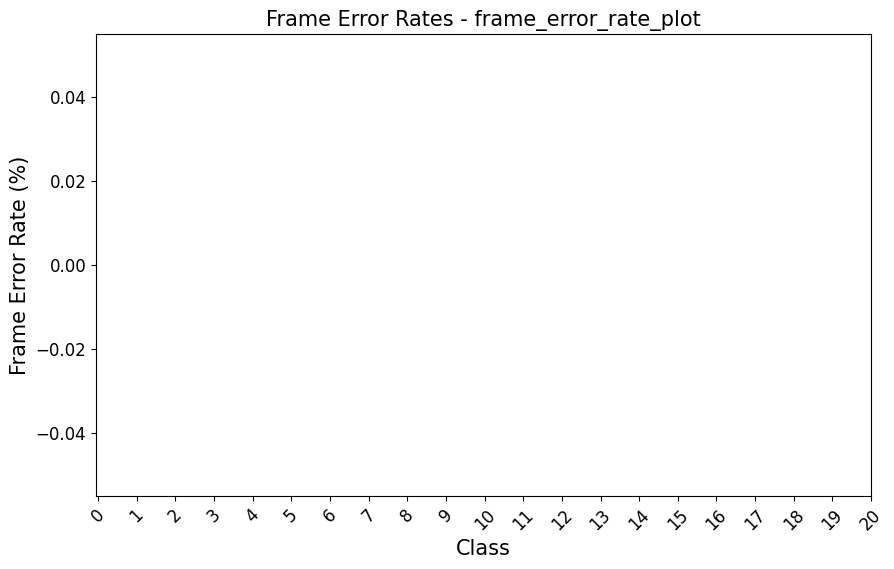

In [5]:
from linear_probe import ModelEvaluator

# Initialize the ModelEvaluator with the filter_unseen_classes feature
evaluator = ModelEvaluator(model=classifier_model, 
                           test_loader=test_loader, 
                           num_classes=num_classes,  # Assuming there are 21 possible classes
                           device='cuda:0',  # Use CUDA if available
                           filter_unseen_classes=True,  # Enable filtering based on training set classes
                           train_dir=train_dir)  # Path to the training dataset directory

# Perform model validation with multiple passes
class_frame_error_rates, total_frame_error_rate = evaluator.evalulate_model(num_passes=1, max_batches=1250)

# Save the results to a specified directory, for example 'evaluation_results'
evaluator.save_results(class_frame_error_rates, total_frame_error_rate, 'results/')
